In [41]:
from qpms import Particle, CTMatrix, lorentz_drude, EpsMuGenerator, TMatrixGenerator, BaseSpec, FinitePointGroup, ScatteringSystem, TMatrixInterpolator, EpsMu, dbgmsg_enable, dbgmsg_disable, dbgmsg_active, BesselType,eV, hbar, c
from qpms.symmetries import point_group_info
import math
import logging
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.INFO)
import numpy as np
eh = eV/hbar
np.random.seed(666)
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle, Circle
from mpl_toolkits.axes_grid1 import AxesGrid

def cleanarray(a, atol=1e-10, copy=True):
    a = np.array(a, copy=copy)
    sieve = abs(a.real) < atol
    a[sieve] = 1j * a[sieve].imag
    sieve = abs(a.imag) < atol
    a[sieve] = a[sieve].real
    return a

In [2]:
dbgmsg_enable(2)
#part_radius = 80e-9

<DebugFlags.THREADS|MISC: 3>

In [88]:
#modefile = '/u/46/necadam1/unix/repo/qpms/misc/modes_basis300nm_0nm__0nm_400nm_n1_b-2_k(0_0)um-1_cn150.npz' # PARAM!
modefile='/l/necadam1/test_mode_fieldplots/cyl_r50nm_h50nm_p560nmx560nm_mAu_n1.52_b-2_k(0_0)um-1_L3_cn200.npz'
#modefile = '/l/necadam1/sqlat-Tommi/sph_r80nm_p580nm_m5.0_n1.52_b-3_k(0_0)um-1_L3_cn3100.npz'
data = np.load(modefile, allow_pickle=True)
meta = data['meta'][()]
list(data.keys())

['meta',
 'empty_freqs',
 'ss_positions',
 'ss_fullvec_poffsets',
 'ss_fullvec_psizes',
 'ss_bspecs_flat',
 'ss_lattice_basis',
 'ss_reciprocal_basis',
 'eigval',
 'eigval_inside_metric',
 'eigvec',
 'residuals',
 'eigval_err',
 'ranktest_SV',
 'iri',
 'blochvector',
 'inside_contour',
 'refractive_index_internal']

In [89]:
# initialise the medium and dummy t-matrix generators, so we can "reconstruct" the ScatSystem instance (only background medium is relevant here)
medium = EpsMuGenerator(meta['background'])
emg_dummy = EpsMuGenerator(10)
tmg_dummy = TMatrixGenerator.sphere(medium, emg_dummy, 50e-9)
try: default_omega = data['eigval'][0]
except IndexError as ie:
    raise ValueError("Data file contains no eigenvalues") from ie
    

In [90]:
# create ss, ssw; init wavevector to use with sswk constructor
particles = []
offsets = data['ss_fullvec_poffsets']
nelems = data['ss_fullvec_psizes']
for pi, pos in enumerate(data['ss_positions']):
    bspec = BaseSpec(data['ss_bspecs_flat'][offsets[pi]:offsets[pi]+nelems[pi]])
    particles.append(Particle(pos, tmg_dummy, bspec))
ss, ssw = ScatteringSystem.create(particles, medium, default_omega, latticebasis = data['ss_lattice_basis'])
wavevector = np.array([0., 0., 0.]) # it needs to be 3D for sswk "constructor", 
for i in range(len(meta['k'])):
    wavevector[i] = meta['k'][i]
    
# determine the "unit rectangle" size for plotting
lb = ss.lattice_basis
xmax = max(abs(lb[0,0]), abs(lb[1,0]))
ymax = max(abs(lb[0,1]), abs(lb[1,1]))
if (xmax > ymax):
    unitrect = (xmax, ss.unitcell_volume/xmax)
else:
    unitrect = (ss.unitcell_volume/ymax, ymax)

In [91]:
eigval_i = 0 # PARAM!
omega = data['eigval'][eigval_i]
fvc = data['eigvec'][eigval_i]

In [92]:
ssw = ss(omega)
sswk = ssw._sswk(wavevector)

In [93]:
ucfactor = 2.2 # "unit cell coverage"; unitrect sizes will be multiplied by this# PARAM!
zfactor = 5 # z range size / sqrt(unitcell_volume) size aspect ratio
resolution = 60 # PARAM!
sqrt_ucvol = math.sqrt(ss.unitcell_volume)
gridsz = [math.ceil(resolution * unitrect[i] / sqrt_ucvol) for i in (0,1)] #x, y
gridsz.append(math.ceil(zfactor / ucfactor * resolution)) # z
gridextent = [[ -(ucfactor * unitrect[i])/2, (ucfactor * unitrect[i] / 2) ] for i in (0,1)]
gridextent.append( [-(zfactor * sqrt_ucvol) / 2, (zfactor * sqrt_ucvol) / 2] )
gridlines = [np.linspace(*gridextent[i], gridsz[i]) for i in range(3)]
gridspacings = [gridlines[i][1]-gridlines[i][0] for i in range(3)] # should be very similar

gridoffsets = [0.,0.,0.] # PARAM!

xygrid = np.stack(np.meshgrid(gridlines[0], gridlines[1], gridoffsets[2], indexing='ij')).T
xygrid.shape=xygrid.shape[1:]
xygrid_s = xygrid - np.array([*gridspacings[:2], 0])/2 # correction of pcolormesh coordinates
xzgrid = np.stack(np.meshgrid(gridlines[0], gridoffsets[1], gridlines[2], indexing='ij')).T
xzgrid.shape = (gridsz[2], gridsz[0], 3)
xzgrid_s = xzgrid - np.array([gridspacings[0], 0, gridspacings[2]])/2

#for imshow
lenscale = 1000e-9 #PARAM!
xyextent = [gridextent[i][j]/lenscale for (i,j) in [(0,0),(0,1),(1,0),(1,1)]]
xzextent = [gridextent[i][j]/lenscale for (i,j) in [(0,0),(0,1),(2,0),(2,1)]]

In [94]:
logging.info("Start calculating xyE")
xyE = cleanarray(sswk.scattered_E(fvc, xygrid), copy=False)
logging.info("Start calculating xzE")
xzE = cleanarray(sswk.scattered_E(fvc, xzgrid), copy=False)
logging.info("Start plotting")

2020-07-04 00:58:30,726 Start calculating xyE
2020-07-04 00:58:44,481 Start calculating xzE
2020-07-04 01:00:51,300 Start plotting


In [95]:
cutoff_ratio_default = 0.03
def cutfield(a, cutoff_ratio=cutoff_ratio_default):
    vmin = np.nanquantile(a, cutoff_ratio)
    vmax = np.nanquantile(a, 1-cutoff_ratio)
    return np.clip(a, vmin, vmax)
    

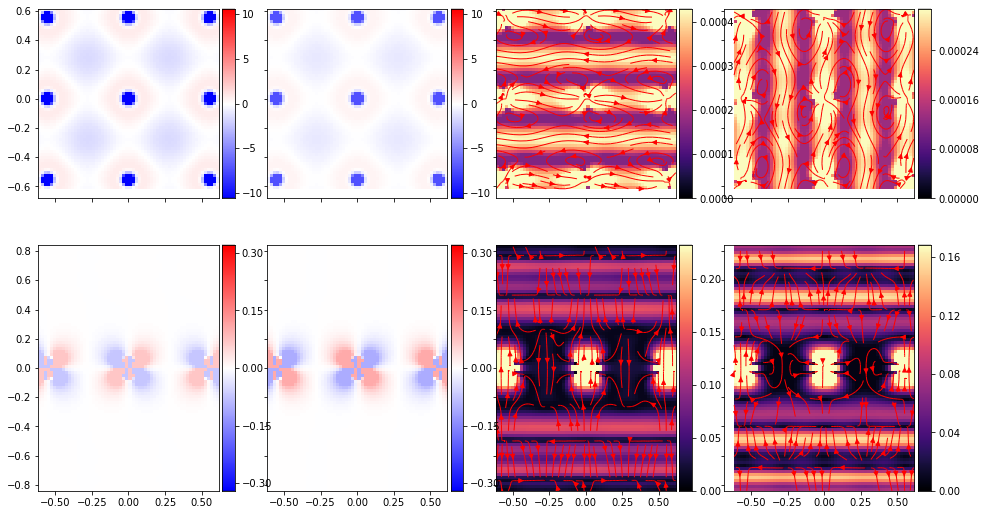

In [103]:
lwfac = 5 #PARAM!


f = plt.figure(figsize=(16, 10))
grid = AxesGrid(f, 111,  # similar to subplot(111)
                nrows_ncols=(2, 4),
                axes_pad=(0.45, 0.65),
                label_mode="L",
                share_all=False,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="7%",
                cbar_pad="2%",
                )
# xy part
ax = grid[0:4]
cbax = grid.cbar_axes[0:4]

flim = max(np.amax(cutfield(abs(xyE[...,2].real))), np.amax(cutfield(abs(xyE[...,2].imag)))) #this is stupid
axi=0
c = ax[axi].imshow(cutfield(xyE[...,2].real), origin='lower', cmap=cm.bwr, extent=xyextent, interpolation='none', vmin = -flim, vmax=flim)#, vmin=vmin, vmax=vmax, interpolation='none')
cb = cbax[axi].colorbar(c)
axi=1
c = ax[axi].imshow(cutfield(xyE[...,2].imag), origin='lower', cmap=cm.bwr, extent=xyextent, interpolation='none', vmin = -flim, vmax=flim)#, vmin=vmin, vmax=vmax, interpolation='none')
cb = cbax[axi].colorbar(c)

axi=2
field = xyE.real[...,:2]
speed = cutfield(np.linalg.norm(field, axis=-1), 0.2)
lw = 1# lwfac*speed/np.amax(speed)
c = ax[axi].imshow(speed, origin='lower', extent=xyextent, cmap=cm.magma, vmin=0, vmax=np.nanquantile(speed, 1-cutoff_ratio_default), interpolation='none')
ax[axi].streamplot(xygrid[...,0]/lenscale, xygrid[...,1]/lenscale, field[...,0], field[...,1],
                      linewidth=lw,color='r'                     )
cb = cbax[axi].colorbar(c)

axi=3
field = xyE.imag[...,:2]
speed = cutfield(np.linalg.norm(field, axis=-1), 0.2)
lw = 1# lwfac*speed/np.amax(speed)
c = ax[axi].imshow(speed, origin='lower', extent=xyextent, cmap=cm.magma, vmin=0, vmax=np.nanquantile(speed, 1-cutoff_ratio_default), interpolation='none')
ax[axi].streamplot(xygrid[...,0]/lenscale, xygrid[...,1]/lenscale, field[...,0], field[...,1],
                      linewidth=lw,color='r'                     )
cb = cbax[axi].colorbar(c)

# xz part
ax = grid[4:8]
cbax = grid.cbar_axes[4:8]


axi=0
flim = max(np.amax(cutfield(abs(xzE[...,1].real))), np.amax(cutfield(abs(xzE[...,1].imag))))  #this is stupid
c = ax[axi].imshow(cutfield(xzE[...,1].real), origin='lower', cmap=cm.bwr, extent=xzextent, interpolation='none', vmin = -flim, vmax=flim)#, vmin=vmin, vmax=vmax, interpolation='none')
cb = cbax[axi].colorbar(c)
axi=1
c = ax[axi].imshow(cutfield(xzE[...,1].imag), origin='lower', cmap=cm.bwr, extent=xzextent, interpolation='none', vmin = -flim, vmax=flim)#, vmin=vmin, vmax=vmax, interpolation='none')
cb = cbax[axi].colorbar(c)

axi=2
field = xzE.real[...,::2]
speed = cutfield(np.linalg.norm(field, axis=-1), 0.05)
lw = 1# lwfac*speed/np.amax(speed)
c = ax[axi].imshow(speed, origin='lower', extent=xzextent, cmap=cm.magma, vmin=0, vmax=np.nanquantile(speed, 1-cutoff_ratio_default), interpolation='none')
ax[axi].streamplot(xzgrid[...,0]/lenscale, xzgrid[...,2]/lenscale, field[...,0], field[...,1],
                      linewidth=lw,color='r'                     )
cb = cbax[axi].colorbar(c)

axi=3
field = xzE.imag[...,::2]
speed = cutfield(np.linalg.norm(field, axis=-1), 0.05)
lw = 1# lwfac*speed/np.amax(speed)
c = ax[axi].imshow(speed, origin='lower', extent=xzextent, cmap=cm.magma, vmin=0, vmax=np.nanquantile(speed, 1-cutoff_ratio_default), interpolation='none')
ax[axi].streamplot(xzgrid[...,0]/lenscale, xzgrid[...,2]/lenscale, field[...,0], field[...,1],
                      linewidth=lw,color='r'                     )
cb = cbax[axi].colorbar(c)


In [97]:
xzgrid.shape

(82, 60, 3)